In [196]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import collections
from collections import Counter
from sklearn import model_selection
from sklearn import metrics
import os
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score as acs
import seaborn as sns
import pickle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [197]:
# open and read the training data 
df = pd.read_csv("train.csv", encoding='utf8')

In [177]:
# Have a look at the dataset: it has 27 columns 
# The prefix N denotes the 10 numerical variables while the prefix C denotes the 12 categorical variables 
# The values of the categorical features have been HASHED onto 32 bits for anonymization purposes
df.head(10)

,label,id,visitTime,purchaseTime,hour,C1,C2,C3,C4,C5,...,N4,N5,N6,N7,N8,N9,N10,C10,C11,C12
0,-1,37,19274330,-1,0,2569487005,1830830742,4228834423,652481754,2967512603,...,0,0,0,0,0,0,0,419316267,3617851689,4220791646
1,-1,55,19274334,-1,0,3191875643,403381353,1238330876,652481754,2967512603,...,0,0,0,0,1,0,0,1968545380,3831440054,1213938795
2,-1,114,19274353,-1,0,2634604934,403381353,1928325921,652481754,2967512603,...,0,0,0,0,0,0,0,1405802835,2379633508,1284343215
3,-1,128,19274358,-1,0,2569487005,403381353,296915027,652481754,2967512603,...,0,0,0,0,0,0,0,2299319102,3617851689,4220791646
4,-1,164,19274367,-1,0,2569487005,403381353,681762206,652481754,2967512603,...,0,0,0,0,0,0,0,1306075469,3617851689,4220791646
5,-1,187,19274374,-1,0,3302106226,403381353,1928325921,652481754,2967512603,...,0,0,0,0,0,0,0,3182036626,2379633508,1284343215
6,-1,191,19274375,-1,0,4176412662,1830830742,2406323306,2308170622,2967512603,...,0,0,0,0,0,0,0,2514494748,3831440054,1213938795
7,-1,194,19274376,-1,0,3199195787,403381353,450016631,652481754,2967512603,...,0,0,0,0,0,0,0,655384408,621902171,1213938795
8,-1,212,19274384,-1,0,2569487005,403381353,3375570753,652481754,2967512603,...,0,0,0,0,0,0,0,1380655399,3617851689,4220791646
9,-1,227,19274387,-1,0,488865880,403381353,1129279372,652481754,2967512603,...,2,0,0,0,2,0,0,2984360656,3831440054,830706566


In [178]:
df.columns

Index(['label', 'id', 'visitTime', 'purchaseTime', 'hour', 'C1', 'C2', 'C3',
       'C4', 'C5', 'C6', 'C7', 'C8', 'N1', 'C9', 'N2', 'N3', 'N4', 'N5', 'N6',
       'N7', 'N8', 'N9', 'N10', 'C10', 'C11', 'C12'],
      dtype='object')

In [179]:
# Let's have a look at our target variable: 1 is purchase and -1 is otherwise 
# It is highly unbalanced: a ratio of 550 to 1
df['label'].value_counts()

-1    31371
 1       57
Name: label, dtype: int64

In [180]:
# We do not know what they mean but we can have a look at some of our variables
df['C1'].value_counts()
# This categorical variable takes many different values
# This can add noise to our data so I will consider removing them

2569487005    8430
2108523568       7
2084406919       6
3438432991       5
256353298        5
              ... 
1427705163       1
4180196685       1
596547023        1
3559230936       1
77004800         1
Name: C1, Length: 22595, dtype: int64

In [181]:
df['C3'].value_counts()

1928325921    1232
3475347077    1212
2780744710    1179
1711803242     936
1822656032     536
              ... 
3540895230       1
2756181513       1
3550862535       1
1199484467       1
1533319149       1
Name: C3, Length: 2863, dtype: int64

In [182]:
df['C10'].value_counts()

3469607743    1425
3458698981      82
3183725626      73
1133005353      71
3662869197      68
              ... 
843115400        1
762569609        1
4142922634       1
830608273        1
487200771        1
Name: C10, Length: 28653, dtype: int64

In [183]:
label = df['label'].values

In [202]:
# We delete label 
# We delete id because it is the unique ID to each user session, the same goes for visitTime 
# We take purchassTime away because it takes the same values as label 
# I end up keeping all categorical variables because it leads to better recall
data = df.drop(columns=['label','id','visitTime','purchaseTime']).values

In [203]:
X = data.copy()
y = np.array(label.copy())
y[:5]

array([-1, -1, -1, -1, -1])

# Split data into training and testing

In [204]:
# We use 80% of the values for training and 20% for testing 

y = (y > 0)*1
nb_class = len(set(y))
print(nb_class)
id_Train = np.array([None]*nb_class)
id_Test = np.array([None]*nb_class)
for i in range(nb_class):
    id_i = np.where(y==i)[0]
    id_i_train, id_i_test = train_test_split(id_i, test_size=0.2)
    id_Train[i] = id_i_train
    id_Test[i] = id_i_test

id_Train = np.concatenate(id_Train)
id_Test = np.concatenate(id_Test)

X_train = X[id_Train]
Y_train = y[id_Train]
X_test = X[id_Test]
Y_test = y[id_Test]

2


In [205]:
X_train[0]

array([         7,  998206083,  403381353, 2780744710,  652481754,
       2116767313, 2304197778, 2303407174, 2374954832,          0,
       3179660634,          0,          0,          0,          0,
                0,          0,          0,          0,          0,
       3469607743,  621902171, 1213938795])

In [206]:
len(X_train)
# The training set now has 25 141 rows (80% of 31 428)

25141

In [207]:
len(X_test)

6287

# Re-sampling

In [208]:
# The baseline code chose to resample to a ratio of 5:1
# I adjust the code to have a ratio of 100:1
# Moving from 550:1 to 5:1 is too big of a change and too far from reality

In [232]:
# We rebalance the training set
# Here, we undersample the number of -1 observations from 25 096 to 22 833 
# We also oversample the number of 1 observations from 45 to 235

id_toTrain = np.array([np.where(Y_train==i)[0] for i in range(nb_class)])

size_max = [len(id_toTrain[i]) for i in range(nb_class)]
print("before resampling")
print(size_max)

blc = 150
for i in range(len(size_max)):
    if size_max[i] > blc:
        size_max[i] = int(blc*(np.log10(size_max[i]/blc)+150))
    else:
        size_max[i] = int(blc/(np.log10(blc/size_max[i]+1)))

print("after resampling")
print(size_max)
for i in range(nb_class):
    if len(id_toTrain[i]) > size_max[i]:
        id_toTrain[i], tmp = train_test_split(id_toTrain[i], test_size=1-size_max[i]/len(id_toTrain[i]))
    else:
        id_toTrain[i] = np.concatenate((id_toTrain[i], id_toTrain[i][np.random.randint(len(id_toTrain[i]), size=int(size_max[i]-len(id_toTrain[i])))]))
id_toTrain = np.concatenate(id_toTrain)
X_toTrain = X_train[id_toTrain]
Y_toTrain = Y_train[id_toTrain]

# The ratio was 550:1 and now it is 100:1

before resampling
[25096, 45]
after resampling
[22833, 235]


In [235]:
# In order totrain my model I will now also rebalance the test set
# I change the blc to have less rows 
# In the end I will test my final model on un unbalanced test set

id_toTest = np.array([np.where(Y_test==i)[0] for i in range(nb_class)])

size_max = [len(id_toTest[i]) for i in range(nb_class)]
print("before resampling")
print(size_max)

blc = 40
for i in range(len(size_max)):
    if size_max[i] > blc:
        size_max[i] = int(blc*(np.log10(size_max[i]/blc)+150))
    else:
        size_max[i] = int(blc/(np.log10(blc/size_max[i]+1)))

print("after resampling")
print(size_max)
for i in range(nb_class):
    if len(id_toTest[i]) > size_max[i]:
        id_toTest[i], tmp = train_test_split(id_toTest[i], test_size=1-size_max[i]/len(id_toTest[i]))
    else:
        id_toTest[i] = np.concatenate((id_toTest[i], id_toTest[i][np.random.randint(len(id_toTest[i]), size=int(size_max[i]-len(id_toTest[i])))]))
id_toTest = np.concatenate(id_toTest)
X_toTest = X_test[id_toTest]
Y_toTest = Y_test[id_toTest]

# The ratio for the test set is 100:1

before resampling
[6275, 12]
after resampling
[6087, 62]


In [236]:
len(X_toTrain)
# The train set now has 23068 rows

23068

In [237]:
len(X_toTest)
# The test set now has 6148 rows

6148

# Model Selection

In [238]:
# I try and improve on the baseline model by using a different algorithm than XGBoost
# We load different classification algorithms 
models = []
models.append(('LR', LogisticRegression(solver='liblinear',multi_class='ovr')))
models.append(('GNB', GaussianNB()))
models.append(('MNB', MultinomialNB()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(max_depth=None)))
models.append(('RF', RandomForestClassifier(n_estimators=100, max_depth=None)))
models.append(('ET', ExtraTreesClassifier(max_depth=None)))
models.append(('GBDT', GradientBoostingClassifier (n_estimators=100, learning_rate=1.0, max_depth=1)))
models.append(('SVM',SVC(gamma='auto',max_iter=3000,probability=True)))

In [239]:
# Evaluate each model and compare metrics
results = []
names = []
for name, model in models:
    model = model.fit(X_toTrain, Y_toTrain)
    y_pred = model.predict(X_toTest)
    precision, recall, fscore, train_support = score(Y_toTest, y_pred, pos_label=1, average='binary')
    accuracy = acs(Y_toTest,y_pred)
    results.append(recall)
    results.append(fscore)
    results.append(accuracy)
    names.append(name)
    msg = "%s: %f %f %f %f" % (name, precision.mean(), recall.mean(), fscore.mean(), accuracy.mean())
    print(msg)
    
# Precision, Recall, FScore, Accuracy
# Gradient Boosted Decision Trees is the best taking into account all metrics
# It has the highest recall, which is what we want to prioritize here

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


LR: 0.000000 0.000000 0.000000 0.989915
GNB: 0.218750 0.112903 0.148936 0.986988
MNB: 0.021990 0.677419 0.042596 0.692908
KNN: 0.000000 0.000000 0.000000 0.984710
CART: 0.890909 0.790323 0.837607 0.996910
RF: 0.980000 0.790323 0.875000 0.997723


/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ET: 1.000000 0.306452 0.469136 0.993006
GBDT: 0.686047 0.951613 0.797297 0.995120


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVM: 0.000000 0.000000 0.000000 0.989915


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


# Gradient Boosted Decision Trees

In [240]:
model = GradientBoostingClassifier()
model = model.fit(X_toTrain, Y_toTrain)
y_pred = model.predict(X_toTest)

precision, recall, fscore, train_support = score(Y_toTest, y_pred, pos_label=1, average='binary')
print('Precision: {} / Recall: {} / F1-Score: {} / Accuracy: {}'.format(round(precision, 3), round(recall, 3), round(fscore,3), round(acs(Y_toTest,y_pred), 3)))

Precision: 0.952 / Recall: 0.952 / F1-Score: 0.952 / Accuracy: 0.999


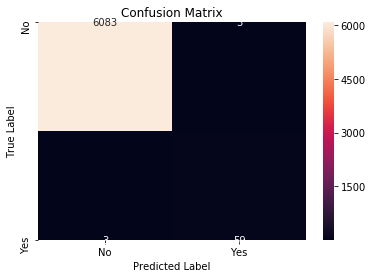

In [241]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_toTest, y_pred)
class_label = ["No", "Yes"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
#plt.savefig('Confusion Matrix.jpg', dpi=1200)
plt.show()

# Out of the 64 purchases, the model classifies 59 correctly 

# Model Evaluation

In [227]:
# Now that the model is trained, we will test it on an unbalanced test set (that is true to reality)
# Re run the code without resampling 

In [242]:
model = GradientBoostingClassifier()
model = model.fit(X_toTrain, Y_toTrain)
y_pred = model.predict(X_test)

precision, recall, fscore, train_support = score(Y_test, y_pred, pos_label=1, average='binary')
print('Precision: {} / Recall: {} / F1-Score: {} / Accuracy: {}'.format(round(precision, 3), round(recall, 3), round(fscore,3), round(acs(Y_test,y_pred), 3)))

Precision: 0.769 / Recall: 0.833 / F1-Score: 0.8 / Accuracy: 0.999


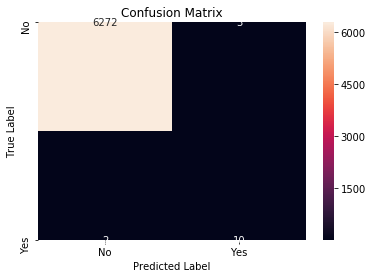

In [243]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, y_pred)
class_label = ["No", "Yes"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
#plt.savefig('Confusion Matrix.jpg', dpi=1200)
plt.show()

# Out of the 12 purchases in the unbalanced test set, the model classifies 10 correctly 

In [ ]:
# I am satisfied with this result so I save this model 

# Testing the test.csv data 

In [244]:
# Save the model to disk
filename = '/Users/olympiahilverda/Desktop/ML/ass 2-3/model.sav'
pickle.dump(model, open(filename, 'wb'))
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

In [245]:
# Open and read the testing data 
testdf = pd.read_csv("test_updated.csv", encoding='utf8')
testdf.head(10)

,label,id,visitTime,purchaseTime,hour,C1,C2,C3,C4,C5,...,N4,N5,N6,N7,N8,N9,N10,C10,C11,C12
0,-1,1,19360733,-1,0,2569487005,403381353,681762206,652481754,2967512603,...,0,0,0,0,0,0,0,2128770044,3617851689,4220791646
1,-1,2,19360734,-1,0,2416811818,1235983246,3653557526,652481754,2116767313,...,0,0,0,0,0,0,0,4256459078,2379633508,1284343215
2,-1,3,19360735,-1,0,3765056181,1235983246,1310333812,652481754,2116767313,...,0,0,0,0,0,0,0,2840358457,3831440054,1213938795
3,-1,4,19360737,-1,0,955802445,403381353,2290282995,652481754,2967512603,...,0,0,0,0,0,0,0,4039873369,535829057,3828748840
4,-1,5,19360752,-1,0,2569487005,2517724481,2463986301,2308170622,2967512603,...,0,0,0,0,0,0,0,907610626,3617851689,4220791646
5,-1,6,19360756,-1,0,2569487005,2541203883,3489340674,2308170622,2967512603,...,0,0,0,0,0,0,0,3341843272,3617851689,4220791646
6,-1,7,19360762,-1,0,2569487005,2541203883,345748658,2308170622,2967512603,...,0,0,0,0,0,0,0,113033895,3617851689,4220791646
7,-1,8,19360768,-1,0,2517733175,1235983246,126861539,652481754,2116767313,...,0,0,0,0,0,0,0,516694455,3831440054,1213938795
8,-1,9,19360788,-1,0,1681988415,1830830742,639836785,2308170622,2967512603,...,0,0,0,0,1,0,0,205952515,3831440054,245608391
9,-1,10,19360790,-1,0,2949940329,2541203883,4222740218,2308170622,2967512603,...,0,0,0,0,0,0,0,1931092700,3831440054,1213938795


In [246]:
testdf['label'].value_counts()
# This test set only has -1's 

-1    32086
Name: label, dtype: int64

In [247]:
testlabel = testdf['label'].values

In [248]:
testdf = testdf.drop(columns=['label','id','visitTime','purchaseTime']).values
testX = pd.DataFrame(testdf.copy())
testy = np.array(testlabel.copy())
testy = (testy > 0)*1

In [249]:
testy = pd.DataFrame(testy)

In [250]:
#creat your train and test set

testy_pred = loaded_model.predict(testX)

result = loaded_model.score(testX, testy)
precision, recall, fscore, train_support = score(testy, testy_pred, pos_label=0, average='binary')
print('Precision: {} / Recall: {} / F1-Score: {} / Accuracy: {}'.format(round(precision, 3), round(recall, 3), round(fscore,3), round(acs(testy,testy_pred), 3)))

print(result)

Precision: 1.0 / Recall: 0.999 / F1-Score: 1.0 / Accuracy: 0.999
0.999283176463255


# Probabilities and exporting csv file

In [251]:
loaded_model.predict_proba(testX)

array([[9.99867601e-01, 1.32399276e-04],
       [9.99916015e-01, 8.39852075e-05],
       [9.99921091e-01, 7.89087586e-05],
       ...,
       [9.99917245e-01, 8.27552156e-05],
       [9.97957526e-01, 2.04247411e-03],
       [9.98293708e-01, 1.70629220e-03]])

In [252]:
prob0=pd.DataFrame(loaded_model.predict_proba(testX)[0:,0])

In [253]:
testdf = pd.read_csv("test_updated.csv", encoding='utf8')

In [254]:
ID = pd.DataFrame(testdf['id'])

In [255]:
finalresult = pd.concat([ID,prob0],axis=1)

In [256]:
finalresult

,id,0
0,1,0.999868
1,2,0.999916
2,3,0.999921
3,4,0.999916
4,5,0.999895
...,...,...
32081,32082,0.999006
32082,32083,0.999917
32083,32084,0.999917
32084,32085,0.997958


In [257]:
finalresult.to_csv('/Users/olympiahilverda/probfinal.csv')